This is the main file for running experiments.
- data_encryption.py has data loading and encryption scripts
- models.py has the implementations of MLP and CNN models we used in this project

Here we implement dataloaders and training scripts for models.

# test dataloaders

In [1]:
from data_encryption import get_text_data, get_voip_data, get_image_data, get_little_data

In [2]:
original, encrypted = get_image_data(engine="AES")
print("AES")
print("Original images:", original.shape)
print("Encrypted images:", encrypted.shape)

original, encrypted = get_image_data(engine="AES", with_entropy=True)
print("AES with entropy")
print("Original images:", original.shape)
print("Encrypted images:", encrypted.shape)

original, encrypted = get_image_data(engine="Salsa")
print("Salsa20")
print("Original images:", original.shape)
print("Encrypted images:", encrypted.shape)
original, encrypted = get_voip_data(engine="Salsa", with_entropy=True)
print("Salsa20 with entropy")
print("Original audio:", original.shape)
print("Encrypted audio:", encrypted.shape)

original, encrypted = get_little_data(engine="RSA")
print("RSA")
print("Original text:", original.shape)
print("Encrypted text:", encrypted.shape)
original, encrypted = get_little_data(engine="RSA", with_entropy=True)
print("RSA wtih entropy")
print("Original text:", original.shape)
print("Encrypted text:", encrypted.shape)

original, encrypted = get_little_data(engine="BFV")
print("BFV")
print("Original text:", original.shape)
print("Encrypted text:", encrypted.shape)
original, encrypted = get_little_data(engine="BFV", with_entropy=True)
print("BFV with entropy")
print("Original text:", original.shape)
print("Encrypted text:", encrypted.shape)

AES
Original images: (10377, 1456)
Encrypted images: (10377, 1456)
AES with entropy
Original images: (10377, 1456)
Encrypted images: (10377, 1458)
Salsa20
Original images: (10434, 1448)
Encrypted images: (10434, 1456)
Salsa20 with entropy
Original audio: (11875, 1448)
Encrypted audio: (11875, 1458)
RSA
Original text: (1245, 210)
Encrypted text: (1245, 256)
RSA wtih entropy
Original text: (1245, 210)
Encrypted text: (1245, 258)
BFV
Original text: (178, 1456)
Encrypted text: (1789, 1456)
BFV with entropy
Original text: (178, 1456)
Encrypted text: (1789, 1458)


# test ML models

## data loading scripts

In [3]:
import numpy as np

def load_originals(engine):
    original_image, _ = get_image_data(engine)
    original_text, _ = get_text_data(engine)
    original_voip, _ = get_voip_data(engine)

    image_labels = np.zeros(original_image.shape[0])
    text_labels = np.ones(original_text.shape[0])
    voip_labels = np.ones(original_voip.shape[0]) * 2

    originals = np.concatenate((original_image, original_text, original_voip))
    labels = np.concatenate((image_labels, text_labels, voip_labels))

    return originals, labels


def load_encrypted(engine):
    _, image = get_image_data(engine)
    _, text = get_text_data(engine)
    _, voip = get_voip_data(engine)

    image_labels = np.zeros(image.shape[0])
    text_labels = np.ones(text.shape[0])
    voip_labels = np.ones(voip.shape[0]) * 2

    encrypted = np.concatenate((image, text, voip))
    labels = np.concatenate((image_labels, text_labels, voip_labels))

    return encrypted, labels

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
def get_dataloaders_for_models(data_loader, engine, batch_size=32, test_size=0.2):
    data, labels = data_loader(engine)

    feature_size = data.shape[1]

    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, stratify=labels, shuffle=True, random_state=42
    )

    train_data, test_data = torch.tensor(train_data, dtype=torch.float32).to(device), torch.tensor(test_data, dtype=torch.float32).to(device)
    train_labels, test_labels = torch.tensor(train_labels, dtype=torch.int64).to(device), torch.tensor(test_labels, dtype=torch.int64).to(device)

    train_dataloader = DataLoader(
        TensorDataset(train_data, train_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
    )
    test_dataloader = DataLoader(
        TensorDataset(test_data, test_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
    )
    n_classes = np.unique(labels).shape[0]

    return train_dataloader, test_dataloader, n_classes, feature_size

## training and evaluation script

In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
import time
import pandas as pd


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

def train_and_evaluate(data_loader, engine, model_class, with_entropy=False, test_size=0.2, reload_data=False, num_epochs=40, batch_size=256):
    inference_time=None

    # prepare data
    train_dataloader, test_dataloader, n_classes, feature_size = get_dataloaders_for_models(data_loader, engine, batch_size, test_size)
    
    # prepare model, criterion, optimizer
    model = model_class(input_size=feature_size, num_classes=n_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # run
    train_losses = []
    train_accuracies = []
    train_aucs = []
    test_accuracies = []
    test_aucs = []
    for epoch in tqdm(range(num_epochs)):
        if reload_data:
            train_dataloader, _, _, _ = get_dataloaders_for_models(data_loader, engine, batch_size, test_size)
            
        model.train()
        epoch_loss = 0.0
        batch_count = len(train_dataloader)
        
        # Training phase
        train_acc = 0.0
        train_auc = 0.0
        for data, labels in train_dataloader:
            data, labels = data.to(device), labels.to(device)
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

            y_class = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            labels = labels.cpu().numpy()
            train_acc += accuracy_score(labels, y_class)

            y_pred = torch.softmax(outputs, dim=1).cpu().detach().numpy()
            train_auc += roc_auc_score(labels, y_pred, multi_class='ovo')
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)
        avg_acc = train_acc / batch_count
        train_accuracies.append(avg_acc)
        avg_auc = train_auc / batch_count
        train_aucs.append(avg_auc)
        
        # Evaluation phase
        model.eval()
        test_acc = 0.0
        test_auc = 0.0
        batch_count = len(test_dataloader)
        with torch.no_grad():
            for data, labels in test_dataloader:
                data, labels = data.to(device), labels.to(device)

                if inference_time is None:
                    start_time = time.time()
                    outputs = model(data)
                    end_time = time.time()

                    inference_time = (end_time - start_time)/data.shape[0]
                else:
                    outputs = model(data)

                y_class = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.cpu().numpy()
                test_acc += accuracy_score(labels, y_class)

                y_pred = torch.softmax(outputs, dim=1).cpu().numpy()
                test_auc += roc_auc_score(labels, y_pred, multi_class='ovo')

        test_accuracies.append(test_acc / batch_count)
        test_aucs.append(test_auc / batch_count)


    # Plot training progress
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 5, 1)
    plt.plot(range(1, num_epochs+1), train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(1, 5, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 5, 3)
    plt.plot(range(1, num_epochs+1), train_aucs)
    plt.title('Training AUC')
    plt.xlabel('Epoch')

    plt.subplot(1, 5, 4)
    plt.plot(range(1, num_epochs+1), test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 5, 5)
    plt.plot(range(1, num_epochs+1), test_aucs)
    plt.title('Test AUC')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()

    print(f"Inference time: {inference_time:.2e} seconds per sample")
    print(f"Best accuracy: {max(test_accuracies):.2f}")
    print(f"Best AUC score: {max(test_aucs):.2f}")

    data_loader_name = data_loader.__name__
    model_name = model_class.__name__
    timestamp = time.strftime("%Y.%m.%d.%H.%M.%S")
    
    save_path = f"./results/{timestamp}_{model_name}_{data_loader_name}_{engine}_entropy_{with_entropy}.csv"
    results_df = pd.DataFrame({
        "Epoch": range(num_epochs),
        "Train Loss": train_losses,
        "Train Accuracy": train_accuracies,
        "Train AUC": train_aucs,
        "Test Accuracy": test_accuracies,
        "Test AUC": test_aucs
    })
    results_df.to_csv(save_path, index=False)



## CNN

100%|██████████| 40/40 [03:55<00:00,  5.89s/it]


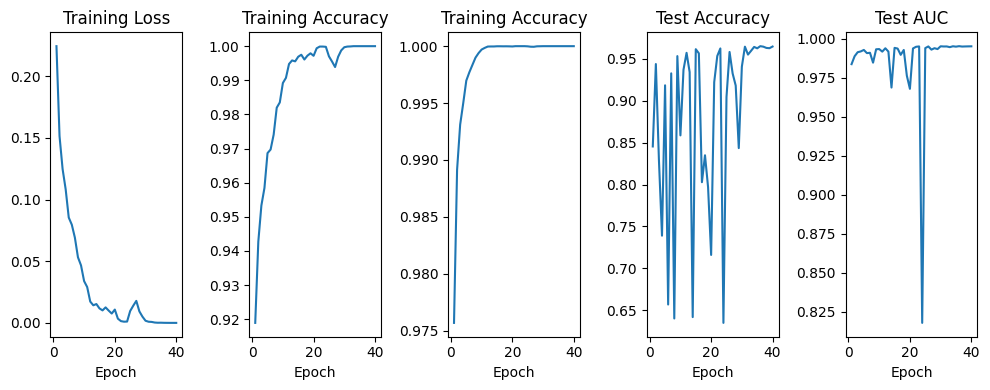

Inference time: 2.40e-04 seconds per sample
Best accuracy: 0.97
Best AUC score: 1.00


In [16]:
from models import CNN, MLP
train_and_evaluate(load_originals, "AES", CNN, num_epochs=40)

100%|██████████| 40/40 [06:07<00:00,  9.19s/it]


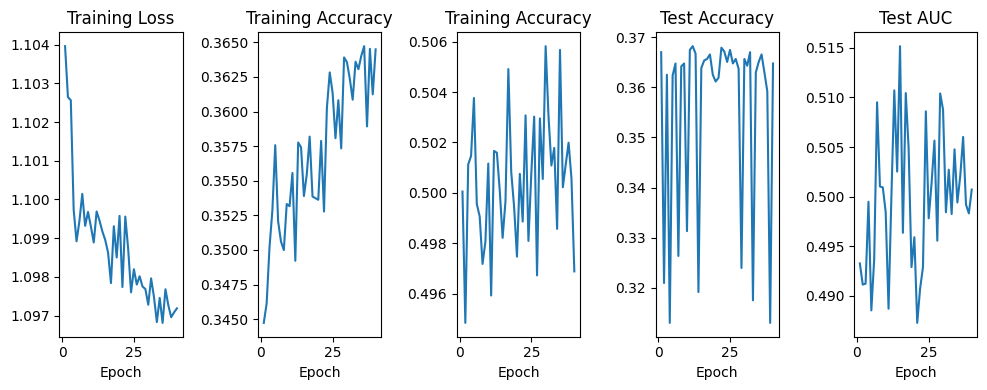

Inference time: 5.73e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.52


In [17]:
train_and_evaluate(load_encrypted, "AES", CNN, with_entropy=False, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [04:21<00:00,  6.53s/it]


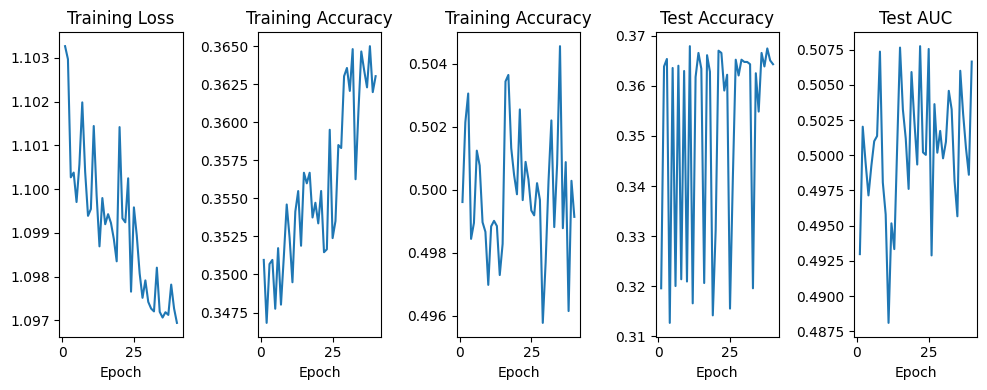

Inference time: 6.99e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.51


In [18]:
train_and_evaluate(load_encrypted, "AES", CNN, with_entropy=True, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [04:14<00:00,  6.36s/it]


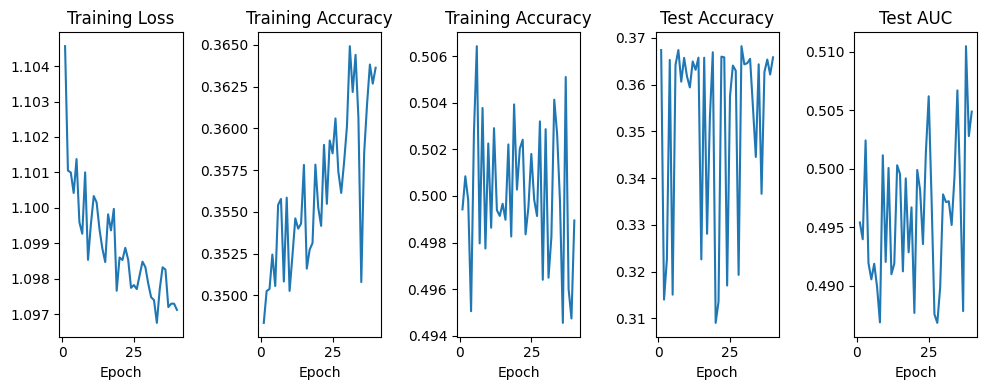

Inference time: 5.80e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.51


In [19]:
train_and_evaluate(load_encrypted, "Salsa", CNN, with_entropy=False, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [04:19<00:00,  6.48s/it]


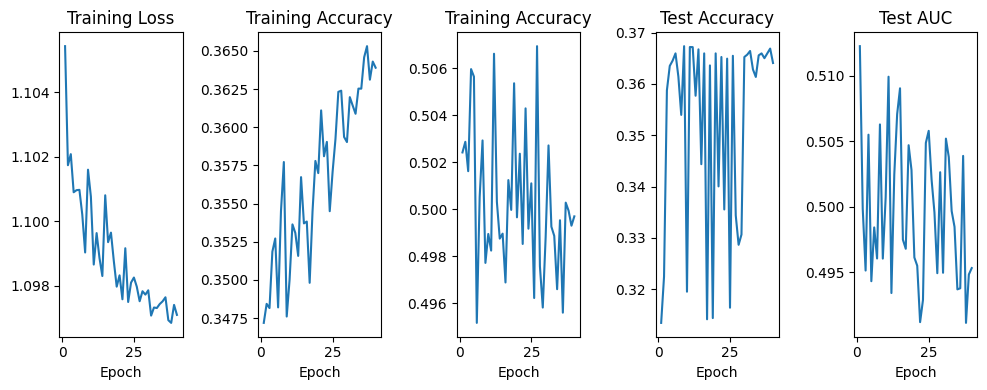

Inference time: 7.83e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.51


In [20]:
train_and_evaluate(load_encrypted, "Salsa", CNN, with_entropy=True, reload_data=True, num_epochs=40)

In [ ]:
train_and_evaluate(load_encrypted, "RSA", CNN, with_entropy=False, reload_data=True, num_epochs=40)

In [ ]:
train_and_evaluate(load_encrypted, "RSA", CNN, with_entropy=True, reload_data=True, num_epochs=40)

In [ ]:
train_and_evaluate(load_encrypted, "BFV", CNN, with_entropy=False, reload_data=True, num_epochs=40)

In [ ]:
train_and_evaluate(load_encrypted, "BFV", CNN, with_entropy=True, reload_data=True, num_epochs=40)

## MLP

100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


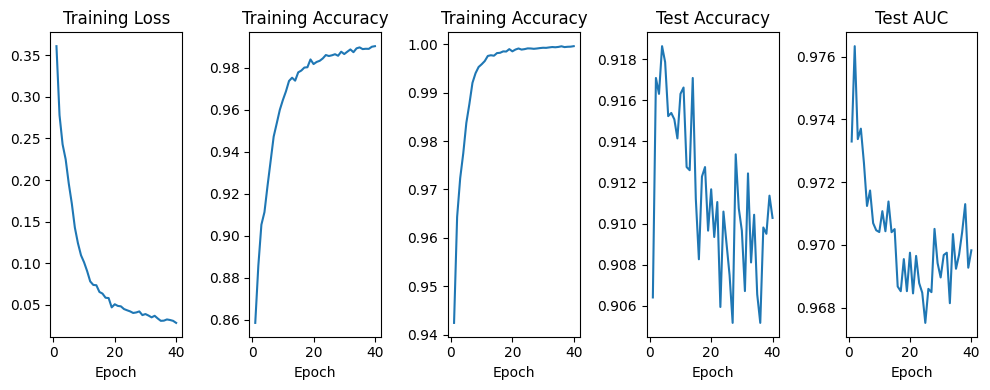

Inference time: 8.08e-06 seconds per sample
Best accuracy: 0.92
Best AUC score: 0.98


In [8]:
from models import CNN, MLP
train_and_evaluate(load_originals, "AES", MLP, num_epochs=40)

100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


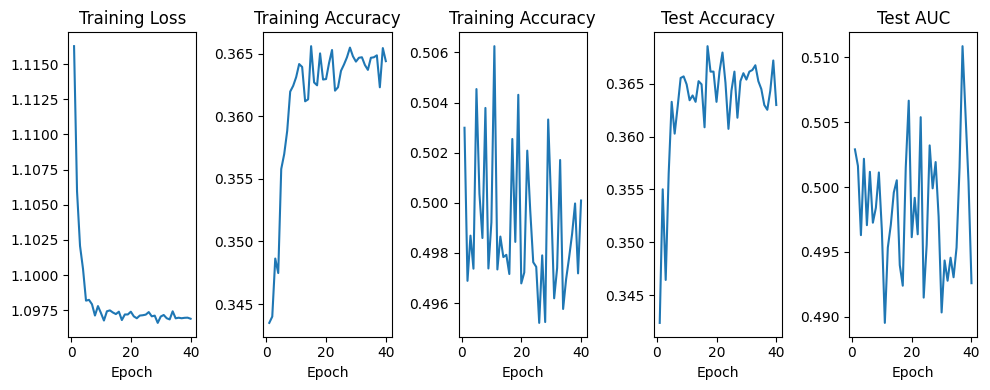

Inference time: 2.11e-05 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.51


In [11]:
train_and_evaluate(load_encrypted, "AES", MLP, with_entropy=False, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [06:06<00:00,  9.16s/it]


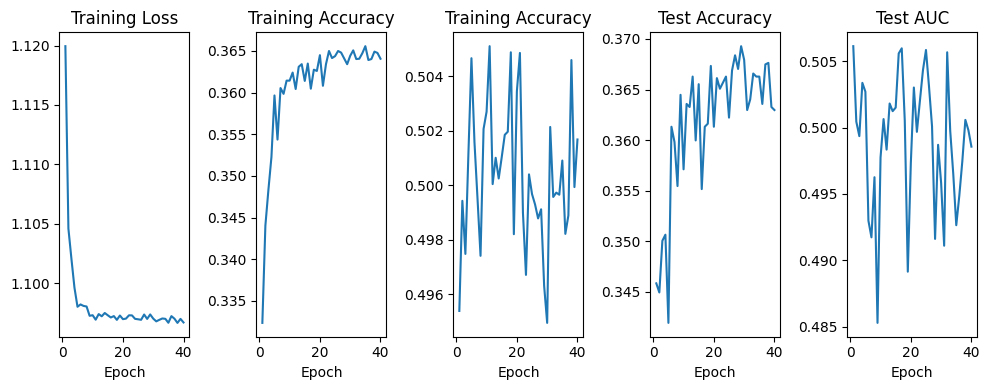

Inference time: 1.41e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.51


In [12]:
train_and_evaluate(load_encrypted, "AES", MLP, with_entropy=True, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [01:25<00:00,  2.14s/it]


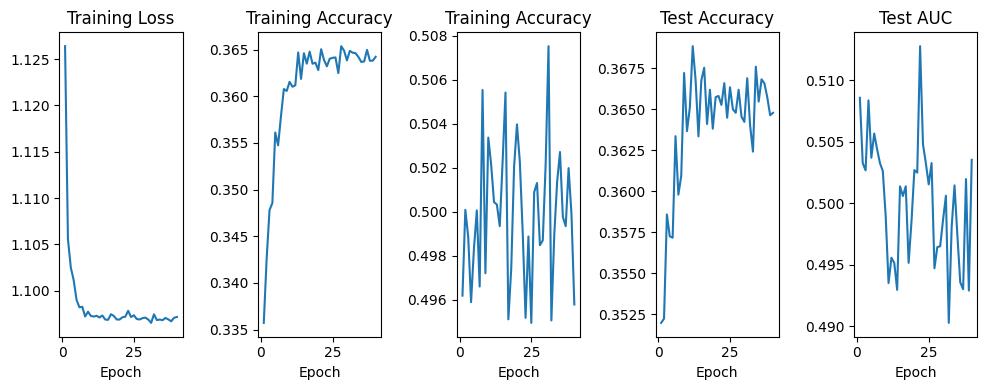

Inference time: 2.98e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.51


In [13]:
train_and_evaluate(load_encrypted, "Salsa", MLP, with_entropy=False, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [01:28<00:00,  2.21s/it]


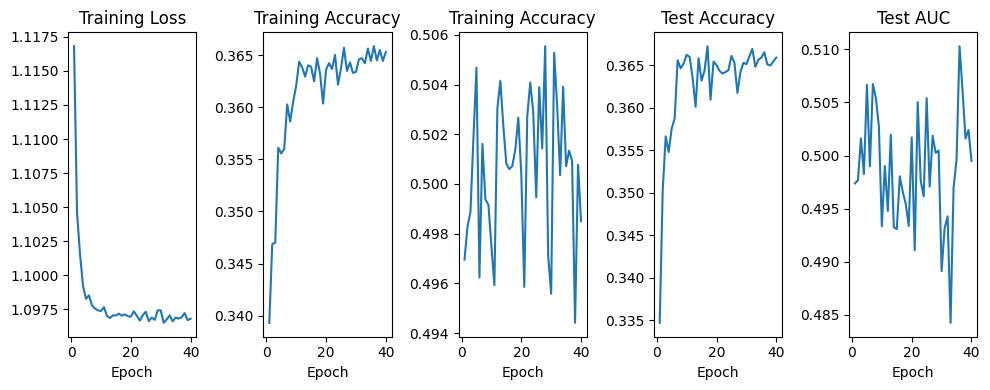

Inference time: 1.68e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.51


In [14]:
train_and_evaluate(load_encrypted, "Salsa", MLP, with_entropy=True, reload_data=True, num_epochs=40)

In [ ]:
train_and_evaluate(load_encrypted, "RSA", MLP, with_entropy=False, reload_data=True, num_epochs=40)

In [ ]:
train_and_evaluate(load_encrypted, "RSA", MLP, with_entropy=True, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [51:03<00:00, 76.59s/it]


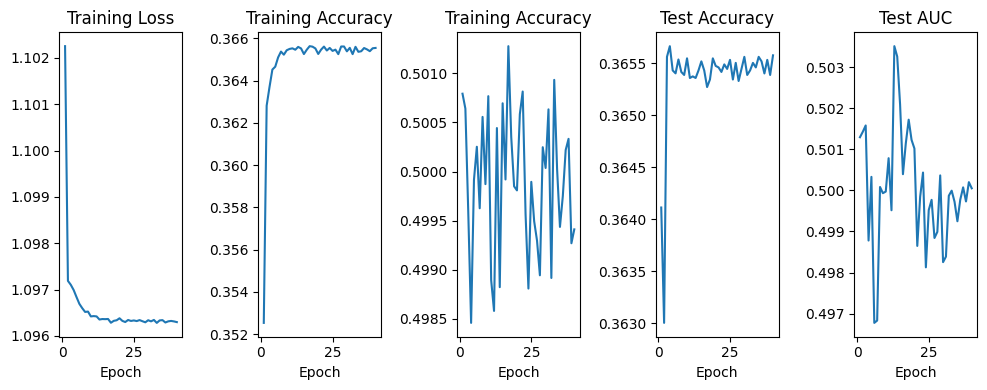

Inference time: 6.39e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.50


In [21]:
train_and_evaluate(load_encrypted, "BFV", MLP, with_entropy=False, reload_data=True, num_epochs=40)

100%|██████████| 40/40 [2:03:44<00:00, 185.61s/it]  


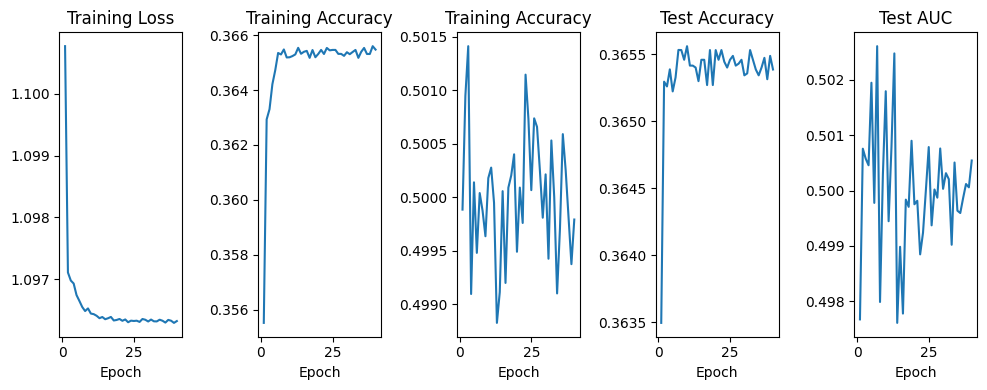

Inference time: 8.09e-06 seconds per sample
Best accuracy: 0.37
Best AUC score: 0.50


In [23]:
train_and_evaluate(load_encrypted, "BFV", MLP, with_entropy=True, reload_data=True, num_epochs=40)

# Plot the results

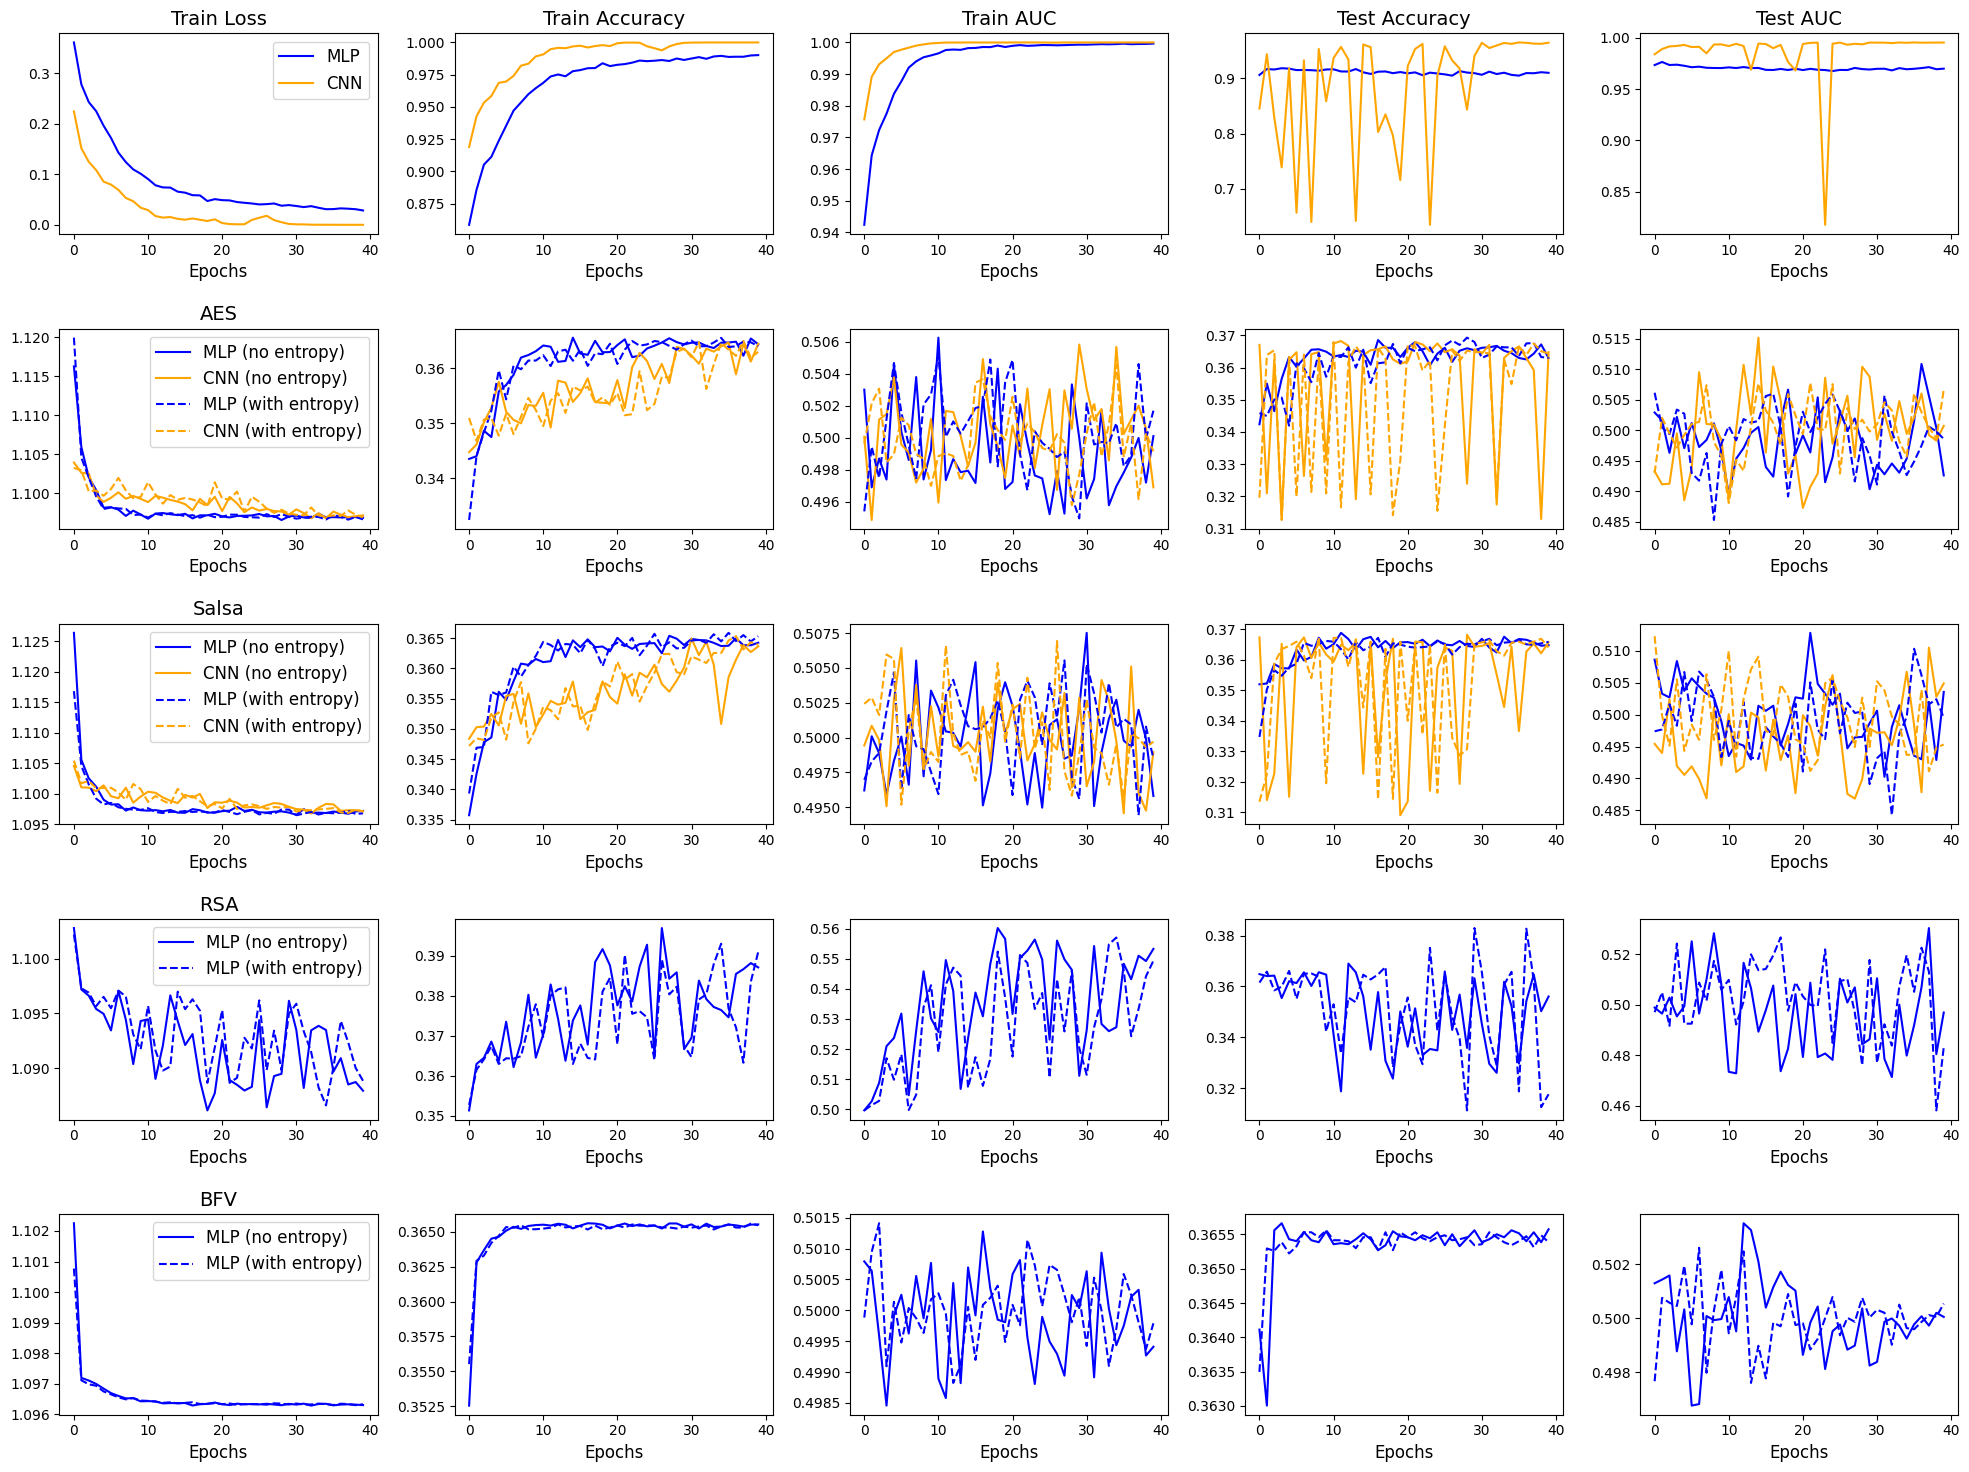

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
plt.rc('font', size=16)  # Default text sizes
plt.rc('axes', titlesize=14)  # Title size
plt.rc('axes', labelsize=12)  # Axes label size
plt.rc('xtick', labelsize=10)  # X-tick label size
plt.rc('ytick', labelsize=10)  # Y-tick label size
plt.rc('legend', fontsize=12)  # Legend font size
plt.rc('figure', titlesize=16)  # Figure title size
# Helper function to load data
def load_csv_files(directory, pattern):
    files = glob.glob(os.path.join(directory, pattern))
    data = {}
    for file in files:
        model = "MLP" if "MLP" in file else "CNN"
        data[model] = pd.read_csv(file)
    return data

# Plotting function
def plot_results(directory):
    # Set up the figure
    fig, axes = plt.subplots(5, 5, figsize=(20, 15))
    fig.tight_layout(pad=5.0)
    
    # Titles for subplots
    metrics = ["Train Loss", "Train Accuracy", "Train AUC", "Test Accuracy", "Test AUC"]
    encryption_methods = ["AES", "Salsa", "RSA", "BFV"]
    
    # Row 1: load_originals
    try:
        data_originals = load_csv_files(directory, "*load_originals*entropy_False.csv")
        for i, metric in enumerate(metrics):
            ax = axes[0, i]
            if "MLP" in data_originals:
                ax.plot(data_originals["MLP"][metric], label="MLP", color="blue")
            if "CNN" in data_originals:
                ax.plot(data_originals["CNN"][metric], label="CNN", color="orange")
            ax.set_title(metric)
            ax.set_xlabel("Epochs")
            if i == 0:
                ax.legend()
    except Exception as e:
        print(f"Error loading or plotting load_originals data: {e}")
    
    # Rows 2-5: Encryption methods
    for row, method in enumerate(encryption_methods, start=1):
        try:
            data_no_entropy = load_csv_files(directory, f"*load_encrypted_{method}*entropy_False.csv")
            data_with_entropy = load_csv_files(directory, f"*load_encrypted_{method}*entropy_True.csv")
            
            for i, metric in enumerate(metrics):
                ax = axes[row, i]
                # Solid lines for entropy_False
                if "MLP" in data_no_entropy:
                    ax.plot(data_no_entropy["MLP"][metric], label="MLP (no entropy)", color="blue")
                if "CNN" in data_no_entropy:
                    ax.plot(data_no_entropy["CNN"][metric], label="CNN (no entropy)", color="orange")
                # Dashed lines for entropy_True
                if "MLP" in data_with_entropy:
                    ax.plot(data_with_entropy["MLP"][metric], linestyle="--", label="MLP (with entropy)", color="blue")
                if "CNN" in data_with_entropy:
                    ax.plot(data_with_entropy["CNN"][metric], linestyle="--", label="CNN (with entropy)", color="orange")
                if i == 0:
                    ax.set_title(method)
                ax.set_xlabel("Epochs")
                if i == 0:
                    ax.legend()
        except Exception as e:
            print(f"Error loading or plotting {method} data: {e}")
    
    # Show the plot
    plt.tight_layout()
    plt.savefig("./results.svg")
    # plt.show()

directory_path = "./results"
plot_results(directory_path)